In [76]:
import numpy as np
import pandas as pd
import datasets

import matplotlib.pyplot as plt
import seaborn as sns

from rdkit import Chem
from rdkit.Chem import AllChem

from openbabel import openbabel, pybel


In [77]:
smls=[
    'CC(C)C1=CC=C(C=C1)C(C)C',
    'CC(C)C1=CC=C(C=C1)C(C)C',
    'CC(C)C1=CC=C(C=C1)C(C)C',
    'CC(C)C1=CC=C(C=C1)C(C)C',
    'CC(C)C1=CC=C(C=C1)C(C)C',
]

## Using OpenBabel

In [103]:
# load smls in a pandas df
df = pd.DataFrame(smls, columns=['smiles'])

In [104]:
m=pybel.readstring('smi', smls[0])
m.OBMol.AddHydrogens()
m.make3D()

conv = openbabel.OBConversion()
conv.SetOutFormat("gzmat")

print(conv.WriteString(m.OBMol))

!Put Keywords Here, check Charge and Multiplicity.
#

 

0  1
C
C  1  r2
C  2  r3  1  a3
C  2  r4  1  a4  3  d4
C  4  r5  2  a5  1  d5
C  5  r6  4  a6  2  d6
C  6  r7  5  a7  4  d7
C  7  r8  6  a8  5  d8
C  8  r9  7  a9  6  d9
C  7  r10  6  a10  5  d10
C  10  r11  7  a11  6  d11
C  10  r12  7  a12  6  d12
H  1  r13  2  a13  3  d13
H  1  r14  2  a14  3  d14
H  1  r15  2  a15  3  d15
H  2  r16  1  a16  3  d16
H  3  r17  2  a17  1  d17
H  3  r18  2  a18  1  d18
H  3  r19  2  a19  1  d19
H  5  r20  4  a20  2  d20
H  6  r21  5  a21  4  d21
H  8  r22  7  a22  6  d22
H  9  r23  8  a23  7  d23
H  10  r24  7  a24  6  d24
H  11  r25  10  a25  7  d25
H  11  r26  10  a26  7  d26
H  11  r27  10  a27  7  d27
H  12  r28  10  a28  7  d28
H  12  r29  10  a29  7  d29
H  12  r30  10  a30  7  d30
Variables:
r2= 1.5349
r3= 1.5340
a3= 108.69
r4= 1.5202
a4= 113.55
d4= 122.06
r5= 1.4007
a5= 121.45
d5= 355.28
r6= 1.3868
a6= 120.65
d6= 186.77
r7= 1.3943
a7= 120.95
d7= 355.76
r8= 1.4006
a8= 119.01
d8=   2.74
r9=

In [105]:
conv = openbabel.OBConversion()
conv.SetOutFormat("gzmat")

df['mol'] = df['smiles'].apply(lambda x: pybel.readstring('smi', x))

#addH and make3D change the mol object and return None. So we need to use a dummy variable to get the return
_ = df['mol'].apply(lambda x: x.OBMol.AddHydrogens())
_ = df['mol'].apply(lambda x: x.make3D())

# Compute xyz. Also accept pdb, sdf and gzmat
df['xyz'] = df['mol'].apply(lambda x: conv.WriteString(x.OBMol))
df

,smiles,mol,xyz
0,CC(C)C1=CC=C(C=C1)C(C)C,CC(C)c1ccc(cc1)C(C)C\t\n,"!Put Keywords Here, check Charge and Multiplic..."
1,CC(C)C1=CC=C(C=C1)C(C)C,CC(C)c1ccc(cc1)C(C)C\t\n,"!Put Keywords Here, check Charge and Multiplic..."
2,CC(C)C1=CC=C(C=C1)C(C)C,CC(C)c1ccc(cc1)C(C)C\t\n,"!Put Keywords Here, check Charge and Multiplic..."
3,CC(C)C1=CC=C(C=C1)C(C)C,CC(C)c1ccc(cc1)C(C)C\t\n,"!Put Keywords Here, check Charge and Multiplic..."
4,CC(C)C1=CC=C(C=C1)C(C)C,CC(C)c1ccc(cc1)C(C)C\t\n,"!Put Keywords Here, check Charge and Multiplic..."


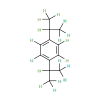

In [106]:
# use openbabel to convert smiles to 3D coordinates

sml=smls[0]
mol = pybel.readstring('smi', sml)
mol.OBMol.AddHydrogens()
mol.make3D()
mol.write('sdf', 'obabel.sdf', overwrite=True)
mol.write('pdb', 'obabel.pdb', overwrite=True)
mol.write('xyz', 'obabel.xyz', overwrite=True)
mol.write('gzmat', 'obabel.zmat', overwrite=True)
mol

### compacting the gzmat

In [ ]:
def replace_variables_in_zmatrix(gzmat):
    lines = gzmat.split('\n')

    variables = {}
    for line in lines:
        if "Variables:" in line:
            # Start of variables section
            index = lines.index(line)
            for variable_line in lines[index+1:]:
                if not variable_line:
                    continue
                var_name, var_value = variable_line.split('=')
                variables[var_name.strip()] = var_value.strip()

    new_lines = []
    for line in lines:
        if "Variables:" in line:
            # Start of variables section, end of file rewrite
            break
        for var_name, var_value in variables.items():
            line = line.replace(var_name, var_value)
        new_lines.append(line)
    return '\n'.join(new_lines)

print(df['xyz'][0])
print(replace_variables_in_zmatrix(df['xyz'][0]))

In [100]:
def replace_variables_in_zmatrix(filename):
    with open(filename, 'r') as file:
        lines = file.readlines()

    variables = {}
    for line in lines:
        if "Variables:" in line:
            # Start of variables section
            index = lines.index(line)
            for variable_line in lines[index+1:]:
                if not variable_line:
                    continue
                var_name, var_value = variable_line[:-1].split('=')
                variables[var_name.strip()] = var_value.strip()

    with open(filename, 'w') as file:
        for line in lines:
            if "Variables:" in line:
                # Start of variables section, end of file rewrite
                break
            for var_name, var_value in variables.items():
                line = line.replace(var_name, var_value)
            file.write(line)

replace_variables_in_zmatrix("obabel.zmat")

## Using RDKit

In [63]:
# load smls in a pandas df
df = pd.DataFrame(smls, columns=['smiles'])

In [101]:
m = Chem.MolFromSmiles(smls[0])
m = Chem.AddHs(m)
AllChem.EmbedMolecule(m)
AllChem.MMFFOptimizeMolecule(m)

# confs = AllChem.EmbedMultipleConfs(m, numConfs=1)
# conf = m.GetConformer(0)

Chem.MolToPDBBlock(m)

'HETATM    1  C1  UNL     1      -3.662   0.808   0.359  1.00  0.00           C  \nHETATM    2  C2  UNL     1      -2.880  -0.492   0.152  1.00  0.00           C  \nHETATM    3  C3  UNL     1      -3.438  -1.280  -1.036  1.00  0.00           C  \nHETATM    4  C4  UNL     1      -1.393  -0.231  -0.000  1.00  0.00           C  \nHETATM    5  C5  UNL     1      -0.493  -0.759   0.934  1.00  0.00           C  \nHETATM    6  C6  UNL     1       0.882  -0.531   0.814  1.00  0.00           C  \nHETATM    7  C7  UNL     1       1.393   0.231  -0.245  1.00  0.00           C  \nHETATM    8  C8  UNL     1       0.493   0.759  -1.180  1.00  0.00           C  \nHETATM    9  C9  UNL     1      -0.882   0.531  -1.059  1.00  0.00           C  \nHETATM   10  C10 UNL     1       2.880   0.492  -0.397  1.00  0.00           C  \nHETATM   11  C11 UNL     1       3.662  -0.808  -0.604  1.00  0.00           C  \nHETATM   12  C12 UNL     1       3.438   1.280   0.791  1.00  0.00           C  \nHETATM   13  H1

In [66]:
df['mol'] = df['smiles'].apply(lambda x: Chem.MolFromSmiles(x))
df['mol'] = df['mol'].apply(lambda x: Chem.AddHs(x))
_ = df['mol'].apply(lambda x: AllChem.EmbedMolecule(x))

# Compute xyz. Also support MolToPDBBlock. Writing sdf is a little different
df['xyz'] = df['mol'].apply(lambda x: Chem.MolToXYZBlock(x))
df

,smiles,mol,xyz
0,CC(C)C1=CC=C(C=C1)C(C)C,<rdkit.Chem.rdchem.Mol object at 0x16417e3b0>,30\n\nC -3.576058 -0.267986 -0.818088\...
1,CC(C)C1=CC=C(C=C1)C(C)C,<rdkit.Chem.rdchem.Mol object at 0x16417e340>,30\n\nC -3.268564 -1.109884 -1.196391\...
2,CC(C)C1=CC=C(C=C1)C(C)C,<rdkit.Chem.rdchem.Mol object at 0x16417e2d0>,30\n\nC 3.294086 1.170645 -0.739856\...
3,CC(C)C1=CC=C(C=C1)C(C)C,<rdkit.Chem.rdchem.Mol object at 0x16417e260>,30\n\nC 3.263697 1.483787 0.576441\...
4,CC(C)C1=CC=C(C=C1)C(C)C,<rdkit.Chem.rdchem.Mol object at 0x16417e0a0>,30\n\nC 3.369477 1.335050 -0.337874\...


In [102]:
# SDWriter('-') writes to stdout
with Chem.SDWriter('rdkit.sdf') as w:
    for cid in range(m.GetNumConformers()):
        print(cid)
        m.SetProp('ID', f'{cid}')
        w.write(m, confId=cid)

Chem.MolToPDBFile(m, 'rdkit.pdb')
Chem.MolToXYZFile(m, 'rdkit.xyz')


0
